In [1]:
%%capture
import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%%capture captured
CLASS_NAMES = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

class SimpleConfig(mrcnn.config.Config):
    NAME = "coco_inference"
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = len(CLASS_NAMES)

model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

model.load_weights("/home/kabilan/Desktop/caption/dataset/mask_rcnn_coco.h5", by_name=True)

2022-05-08 13:28:33.028221: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-05-08 13:28:39.291421: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-08 13:28:39.291481: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kabilan-pt4987): /proc/driver/nvidia/version does not exist
2022-05-08 13:28:39.293506: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-08 13:28:39.332939: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2599990000 Hz
2022-05-08 13:28:39.334999: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x562b499d0b70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-08

In [3]:
class Node:
    def __init__(self,start,end,class_id,class_name):
        self.start = start
        self.end = end
        self.class_id = class_id
        self.class_name = class_name
        
    def get_area(self):
        height = self.end[1] - self.start[1]
        width = self.end[0] - self.start[0]
        return width * height

In [4]:
def get_objects_and_locations(image_path):
    image = cv2.imread(image_path,1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    rois = model.detect([image], verbose=0)[0]
    return rois

In [5]:
def get_angle(node_a,node_b):
    x1,y1 = node_a.end
    x2,y2 = node_b.end
    tan = (y2-y1)/(x2-x1)
    return tan

def distance(node_a,node_b):
    return np.linalg.norm(np.array(node_a.end) - np.array(node_b.end))

In [6]:
def get_nodes(res):
    objects = []
    for i in range(len(res['rois'])):
        class_name = CLASS_NAMES[res['class_ids'][i]]
        class_id = res['class_ids'][i]
        points = res['rois'][i]
        start = (points[1],points[0])
        end = (points[3],points[2])
        score = res['scores'][i]
        ob = Node(start,end,class_id,class_name)
        if score > 0.8:
            objects.append(ob)
    return objects

In [17]:
def parse_direction(pos_node,old_target_node,target_node):
    dir_str = ""
    angle = get_angle(pos_node,target_node)
    movement = ""
    if angle < -1.0:
        movement = "right"
    elif angle > 1.0:
        movement = "left"
    else:
        movement = "front"
    dis_str = ""
    if old_target_node is not None:
        if old_target_node.get_area() < target_node.get_area():
            dis_str = "getting closer to"
        else:
            dis_str = "moving away from"
    if dis_str == "":
        return f"move {movement}"
    return f" Your are {dis_str} {CLASS_NAMES[target_node.class_id]},move {movement} "

In [18]:
def load_image_and_get_res_pos_node(each):
    img_path = "/home/kabilan/Desktop/caption/steps/"+each
    image = cv2.imread(img_path,1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    im_width,im_height = image.shape[1],image.shape[0] 
    cur_pos = (im_height,int(im_width/2)) 
    pos_node = Node(cur_pos,cur_pos,-1,"current_position") 
    res = get_objects_and_locations(img_path)
    plt.imshow(image)
    plt.show()
    return pos_node,res

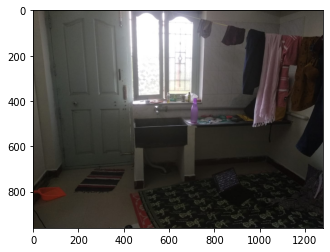

move front


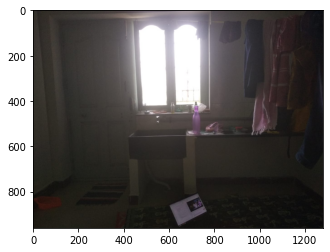

 Your are getting closer to bottle,move front 


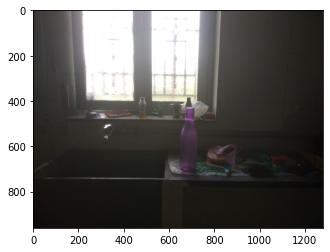

 Your are moving away from bottle,move front 


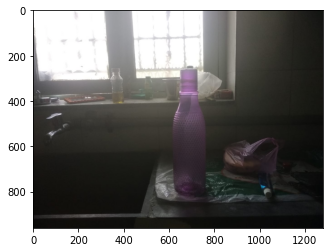

 Your are getting closer to bottle,move right 


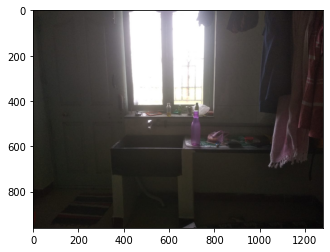

 Your are moving away from bottle,move front 


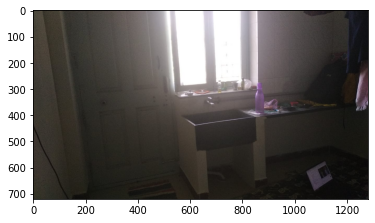

 Your are moving away from bottle,move right 


In [19]:
target_node = None
target_class_id = CLASS_NAMES.index('bottle') 

for each in os.listdir('../steps'):
    pos_node ,res = load_image_and_get_res_pos_node(each)
    objects = get_nodes(res)
    for each in objects:
        if each.class_id == target_class_id:
            print(parse_direction(pos_node,target_node,each))
            target_node = each
            break